<a href="https://colab.research.google.com/github/miller0926/Keras_tutorial/blob/master/ch05_SGD_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
from fastai.basics import *

##MNIST SGD
随机梯度下降

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/Shared drives/gg/Materials"
base_dir = root_dir + 'data'

Mounted at /content/drive


In [0]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz -p /content/drive/Shared drives/aa/s

--2020-04-14 10:42:13--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘deeplearning.net/data/mnist/mnist.pkl.gz’

deeplearning.net/da 100%[===================>]  15.42M  10.7MB/s    in 1.4s    

2020-04-14 10:42:14 (10.7 MB/s) - ‘deeplearning.net/data/mnist/mnist.pkl.gz’ saved [16168813/16168813]

/content/drive/Shared: Scheme missing.
--2020-04-14 10:42:14--  http://drives/aa/s
Resolving drives (drives)... failed: Name or service not known.
wget: unable to resolve host address ‘drives’
FINISHED --2020-04-14 10:42:14--
Total wall clock time: 1.7s
Downloaded: 1 files, 15M in 1.4s (10.7 MB/s)


In [0]:
path = '/content/drive/Shared drives/gg/Materials/data'

In [0]:
with gzip.open(path + '/mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

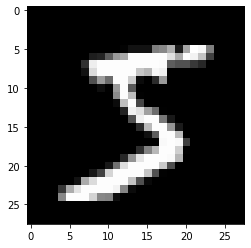

In [5]:
plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
x_train.shape

In [6]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

n, c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

#### 利用pytorch中SGD来完成 minibatches

In [0]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [8]:
train_ds[:10]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4]))

In [9]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class Mnist_Logistic(nn.Module):

    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
    
    def forward(self, xb):
        return self.lin(xb)

In [0]:
model = Mnist_Logistic().cuda()

In [12]:
!nvidia-smi

Tue Apr 14 12:19:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    34W / 250W |    717MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [13]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [14]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [15]:
model(x).shape

torch.Size([64, 10])

In [16]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr = 2e-2

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
def update(x, y, lr):

    wd = 1e-5
    y_hat = model(x)

    #weight decay
    w2 = 0.
    for p in model.parameters():
        w2 += (p**2).sum()
    
    #add to regular  loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()

    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [0]:
losses = [update(x, y, lr) for x, y in data.train_dl]

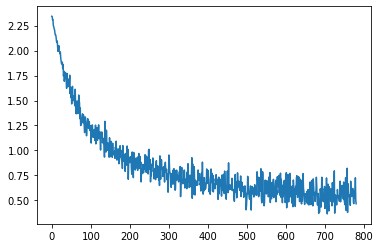

In [21]:
plt.plot(losses)

In [0]:
class MNist_NN(nn.Module):

    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
    
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [0]:
model = MNist_NN().cuda()

In [0]:
losses = [update(x, y, lr) for x, y in data.train_dl]

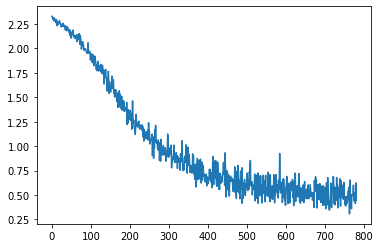

In [25]:
plt.plot(losses)

In [0]:
model = MNist_NN().cuda()

In [0]:
def update(x, y, lr):

    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x, y, 1e-3) for x, y in data.train_dl]

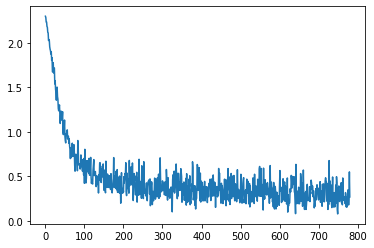

In [29]:
plt.plot(losses)

In [0]:
learn = Learner(data, MNist_NN(), loss_func=loss_func, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


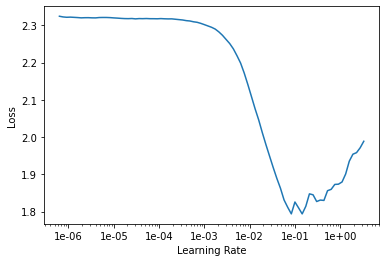

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.190871,0.175346,0.948100,00:04
1,0.103725,0.098209,0.970700,00:04


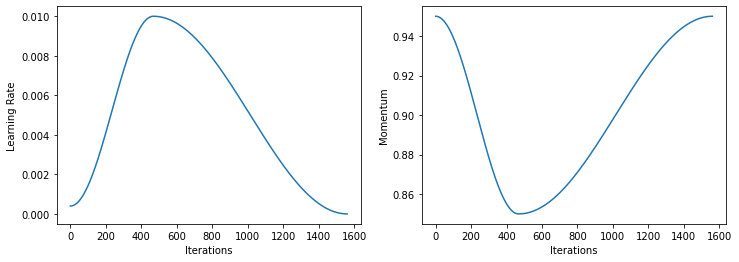

In [33]:
learn.recorder.plot_lr(show_moms=True)

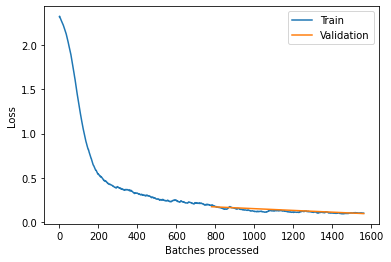

In [34]:
learn.recorder.plot_losses()